In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- Configurações Iniciais ---
TICKER_PARA_TREINAR = "PETR4.SA"
CAMINHO_DADOS_PROCESSADOS = "../data/03_processed"
CAMINHO_MODELOS = "../models"

print("Bibliotecas importadas e configurações prontas.")

2025-09-10 01:33:40.861094: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-10 01:33:40.915511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/alex/Projetos/TCC_2025/.venv/lib64/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/alex/Projetos/TCC_2025/.venv/lib64/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major

Bibliotecas importadas e configurações prontas.


In [2]:
# Carrega os arrays do disco
X_train = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_PARA_TREINAR}_X_train.npy'))
y_train = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_PARA_TREINAR}_y_train.npy'))
X_test = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_PARA_TREINAR}_X_test.npy'))
y_test = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_PARA_TREINAR}_y_test.npy'))

# Verifica os formatos para garantir que tudo foi carregado corretamente
print("Formatos dos dados carregados:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Formatos dos dados carregados:
X_train shape: (5099, 60, 1)
y_train shape: (5099,)
X_test shape: (1230, 60, 1)
y_test shape: (1230,)


In [3]:
# Usaremos um modelo Sequencial, que é uma pilha linear de camadas.
model = Sequential()

# Camada 1: A primeira camada LSTM
# 'units=50': Define 50 neurônios na camada.
# 'return_sequences=True': Essencial para empilhar outra camada LSTM em seguida.
# 'input_shape': Informa à primeira camada o formato dos dados de entrada (60 dias, 1 feature).
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Técnica para evitar overfitting

# Camada 2: A segunda camada LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada 3: Uma camada Densa (tradicional)
model.add(Dense(units=25))

# Camada 4: A Camada de Saída
model.add(Dense(units=1)) # Apenas 1 neurônio, pois queremos prever 1 valor (o preço).

print("Arquitetura do modelo construída.")

Arquitetura do modelo construída.


2025-09-10 01:36:34.630539: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/alex/Projetos/TCC_2025/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# Compila o modelo, configurando o otimizador e a função de erro
model.compile(optimizer='adam', loss='mean_squared_error')

# Mostra um resumo da arquitetura do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
print("\nIniciando o treinamento do modelo...")

# O método .fit() é onde o treinamento acontece.
# validation_data permite monitorar o erro no conjunto de teste a cada época.
history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test)
)

print("\nTreinamento concluído!")


Iniciando o treinamento do modelo...
Epoch 1/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0039 - val_loss: 0.0712
Epoch 2/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0014 - val_loss: 0.0268
Epoch 3/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0012 - val_loss: 0.0270
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0011 - val_loss: 0.0220
Epoch 5/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0011 - val_loss: 0.0067
Epoch 6/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 9.7573e-04 - val_loss: 0.0032
Epoch 7/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 9.6336e-04 - val_loss: 0.0211
Epoch 8/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 9.1762e-04 - val_loss: 0.0168
Epoch 9/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 9.0420e-04 - val_loss: 0.0173
Epoch 10/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 9.2851e-04 - val_loss: 0.0071
Epoch 11/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 8.7937e-0

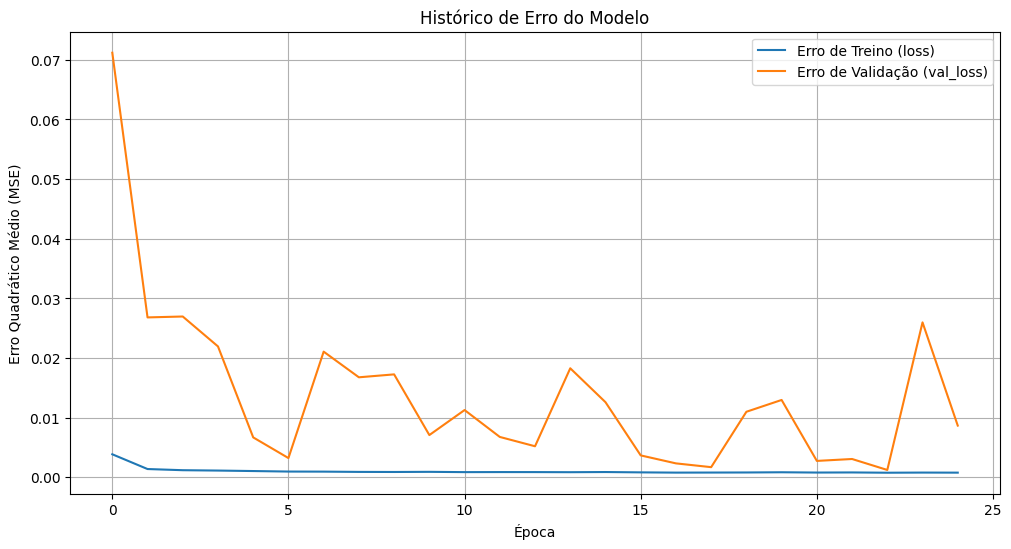

In [6]:
# Este gráfico nos ajuda a ver se o modelo está aprendendo bem ou decorando (overfitting)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Erro de Treino (loss)')
plt.plot(history.history['val_loss'], label='Erro de Validação (val_loss)')
plt.title('Histórico de Erro do Modelo')
plt.xlabel('Época')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Salva o modelo treinado na pasta 'models'
caminho_modelo_salvo = os.path.join(CAMINHO_MODELOS, f"{TICKER_PARA_TREINAR}_lstm_model.h5")
model.save(caminho_modelo_salvo)

print(f"\nModelo salvo com sucesso em: '{caminho_modelo_salvo}'")


Modelo salvo com sucesso em: '../models/PETR4.SA_lstm_model.h5'
